#FINRL Portfolio Allocation

#Install all the packages through FinRL library


In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-2vmyqis9
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-2vmyqis9
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-jnur18dc/pyfolio_5630e41f09bf4106a397f8edf0391cc6
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-jnur18dc/pyfolio_5630e41f09bf4106a397f8edf0391cc6
     |████████████████████████████████| 172 kB 7.7 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 6.3 MB 44.8 MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-py3-none-any.whl size=66426 sha256=1368a32c2aa6b6048ca00320f88bb820d2d05fc491d22a3c4132ed0f08a37834
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvllq4k9/wheels/17/ff/bd/1bc602a0352762b0b24041b88536d803ae343ed0a711fcf55e
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=757

#Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts


import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

#Download Data

In [4]:
print(config.DOW_30_TICKER)


['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [5]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-07-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df.head()


,date,open,high,low,close,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,5.974743,1079178800,AAPL,2
1,2008-01-02,52.090000,52.320000,50.790001,40.795723,8053700,AXP,2
2,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA,2
3,2008-01-02,72.559998,72.669998,70.050003,47.896084,6337800,CAT,2
4,2008-01-02,27.000000,27.299999,26.209999,19.569740,64338900,CSCO,2


#Preprocess Data

In [7]:

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [8]:
df.head()


,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30
0,2008-01-02,7.116786,7.152143,6.876786,5.974743,1079178800,AAPL,2,0.0,100.0,-66.666667,100.0
3398,2008-01-02,52.090000,52.320000,50.790001,40.795723,8053700,AXP,2,0.0,100.0,-66.666667,100.0
6796,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA,2,0.0,100.0,-66.666667,100.0
10194,2008-01-02,72.559998,72.669998,70.050003,47.896084,6337800,CAT,2,0.0,100.0,-66.666667,100.0
13592,2008-01-02,27.000000,27.299999,26.209999,19.569740,64338900,CSCO,2,0.0,100.0,-66.666667,100.0


##Add covariance matrix as states

In [9]:

# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [10]:
df.shape


(91234, 14)

In [11]:
df.head()


,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.617247,607541200,AAPL,2,-0.083669,42.254778,-80.491633,16.129793,"[[0.0013489688855373024, 0.000990979372521563,...",tic AAPL AXP BA ... ...
1,2008-12-31,17.969999,18.750000,17.910000,15.025569,9625600,AXP,2,-0.964124,42.554845,-75.362550,25.776759,"[[0.0013489688855373024, 0.000990979372521563,...",tic AAPL AXP BA ... ...
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,-0.279798,47.440267,156.995097,5.366299,"[[0.0013489688855373024, 0.000990979372521563,...",tic AAPL AXP BA ... ...
3,2008-12-31,43.700001,45.099998,43.700001,31.095800,6277400,CAT,2,0.688541,51.205314,98.432308,26.331746,"[[0.0013489688855373024, 0.000990979372521563,...",tic AAPL AXP BA ... ...
4,2008-12-31,16.180000,16.549999,16.120001,12.019092,37513700,CSCO,2,-0.102729,45.961924,11.978197,13.387087,"[[0.0013489688855373024, 0.000990979372521563,...",tic AAPL AXP BA ... ...


#Design Environment

In [12]:
train = data_split(df, '2009-01-01','2020-07-01')


In [13]:
train.head()


,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4,-0.071058,45.440192,-32.083886,2.140064,"[[0.001366150477084819, 0.0010028349094392064,...",tic AAPL AXP BA ... ...
0,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4,-0.857433,43.957537,-42.753090,16.335101,"[[0.001366150477084819, 0.0010028349094392064,...",tic AAPL AXP BA ... ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,-0.002007,50.822042,272.812831,20.494464,"[[0.001366150477084819, 0.0010028349094392064,...",tic AAPL AXP BA ... ...
0,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4,0.875031,53.661249,129.760396,34.637448,"[[0.001366150477084819, 0.0010028349094392064,...",tic AAPL AXP BA ... ...
0,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,-0.061562,48.322168,54.454064,2.653808,"[[0.001366150477084819, 0.0010028349094392064,...",tic AAPL AXP BA ... ...


#Environment for Portfolio Allocation

In [14]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [15]:

stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 29


In [16]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [17]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


#Implement DRL ALgorithms
##Model 1: A2C

In [18]:
# initialize
agent = DRLAgent(env = env_train)

In [19]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [20]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 148      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -41.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 1.88e+08 |
|    std                | 0.999    |
|    value_loss         | 2.49e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 204      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -41.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |
|

#Trading

In [21]:
trade = data_split(df,'2020-07-01', '2021-07-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [22]:
trade.shape


(7308, 14)

In [23]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1395422.8899870343
Sharpe:  2.290256266484069
hit end!


In [24]:
df_daily_return.head()


,date,daily_return
0,2020-07-01,0.000000
1,2020-07-02,0.005950
2,2020-07-06,0.015982
3,2020-07-07,-0.016217
4,2020-07-08,0.005170


In [25]:
df_daily_return.to_csv('df_daily_return.csv')


In [26]:
df_actions.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483
2020-07-02,0.023458,0.040639,0.023458,0.061558,0.031740,0.023458,0.023458,0.063764,0.063764,0.063764,0.040209,0.023458,0.026141,0.030536,0.023458,0.023458,0.023458,0.036640,0.040643,0.030318,0.027226,0.023458,0.023561,0.023458,0.038828,0.035416,0.063764,0.023458,0.023458
2020-07-06,0.037089,0.032330,0.062719,0.024007,0.023073,0.023073,0.023073,0.062719,0.023073,0.027663,0.023073,0.023073,0.062719,0.023073,0.062719,0.026061,0.035058,0.024635,0.038974,0.058756,0.030154,0.041267,0.023073,0.024799,0.023073,0.062719,0.023073,0.031808,0.023073
2020-07-07,0.025708,0.025708,0.025708,0.025708,0.041571,0.038099,0.030474,0.032062,0.069881,0.025708,0.025708,0.025708,0.051691,0.030622,0.025708,0.025708,0.069881,0.069881,0.025708,0.025708,0.025708,0.025708,0.025708,0.027856,0.062151,0.025708,0.025708,0.029512,0.034995
2020-07-08,0.025145,0.025145,0.038561,0.025145,0.025145,0.030956,0.031817,0.054731,0.051296,0.030467,0.025145,0.025145,0.025145,0.068352,0.025145,0.025145,0.025145,0.025145,0.025145,0.068352,0.036151,0.025145,0.068352,0.025145,0.025145,0.068352,0.025145,0.025145,0.025145


In [27]:
df_actions.to_csv('df_actions.csv')


#Backtest Our Strategy
##BackTestStats

In [28]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [29]:

print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.395423
Cumulative returns     0.395423
Annual volatility      0.150500
Sharpe ratio           2.290256
Calmar ratio           4.904699
Stability              0.946505
Max drawdown          -0.080621
Omega ratio            1.468574
Sortino ratio          3.615554
Skew                   0.010866
Kurtosis               1.432829
Tail ratio             1.137311
Daily value at risk   -0.017593
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [30]:

#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.334042
Cumulative returns     0.332517
Annual volatility      0.146033
Sharpe ratio           2.055458
Calmar ratio           3.740347
Stability              0.945402
Max drawdown          -0.089308
Omega ratio            1.408111
Sortino ratio          3.075978
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078766
Daily value at risk   -0.017207
dtype: float64


## BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 8)


Start date,2020-07-01
End date,2021-06-30
Total months,12
,Backtest
Annual return,39.542%
Cumulative returns,39.542%
Annual volatility,15.05%
Sharpe ratio,2.29
Calmar ratio,4.90
Stability,0.95
Max drawdown,-8.062%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.06,2020-09-02,2020-10-28,2020-11-09,49
1,4.72,2021-06-04,2021-06-18,NaT,NaN
2,3.47,2021-01-14,2021-01-29,2021-02-05,17
3,2.91,2021-02-24,2021-02-26,2021-03-08,9
4,2.84,2021-05-10,2021-05-12,2021-06-02,18


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


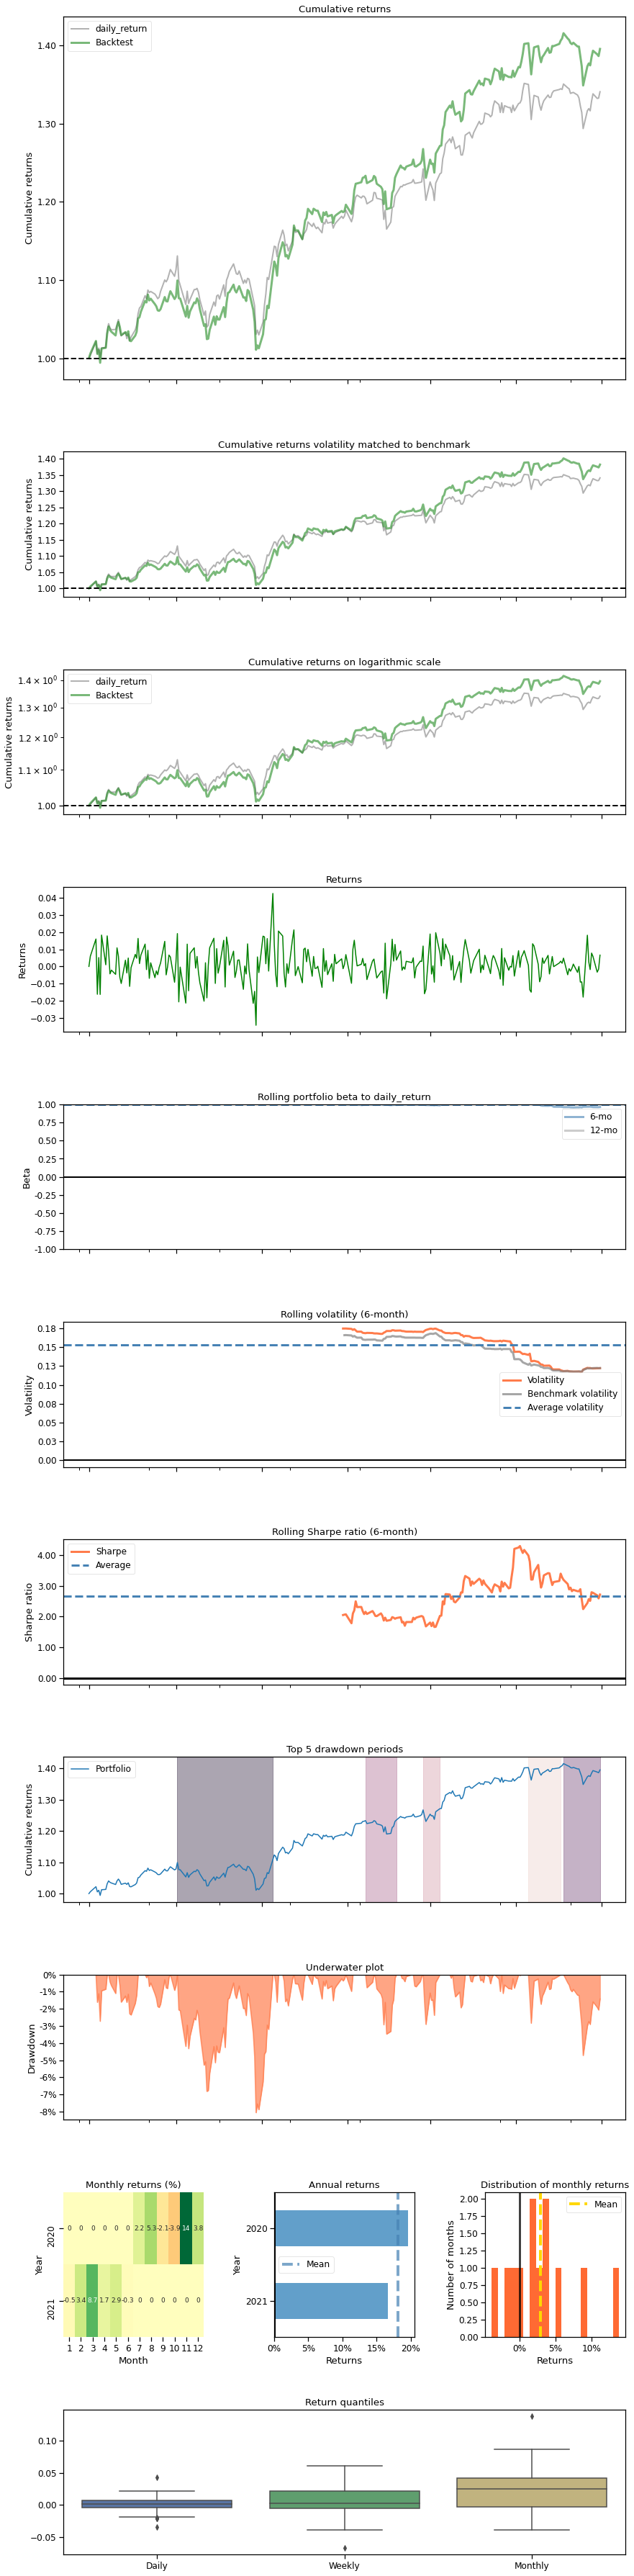

In [31]:

import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-07-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)